In [1]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [25]:
import importlib
importlib.reload(utils)

<module 'utils' from '/home/nick/bci-challenge-ner15/utils.py'>

In [27]:
raw_data = pd.read_csv('data/train/Data_S06_Sess04.csv')
feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
feedback_indices = feedback_times.index
fs = 200 # sampling frequency

filtered_data = utils.bandpass_filter_all(raw_data, highcut=30)

In [15]:
part, _ = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=0, before=0.0, after=1.3)
part = part[utils.important_channels]
print(type(part))
print(part.shape)
part.head()

<class 'pandas.core.frame.DataFrame'>
(261, 16)


,Cz,Pz,FCz,Fz,C1,CP1,CPz,CP2,C2,C3,FC3,P1,FC1,FC2,F1,C4
4708,-20.340508,-17.984175,-21.251811,-14.412942,-15.935417,-17.453515,-19.784476,-13.972082,-20.625266,-15.339290,-13.011358,-19.291751,-21.458803,-16.809161,-15.666633,-11.184115
4709,-18.579182,-15.087330,-19.900292,-12.977435,-14.632315,-15.493818,-17.615908,-11.670802,-18.885096,-14.084301,-11.884119,-17.035691,-20.236751,-14.976239,-14.267098,-9.094632
4710,-15.447053,-10.935946,-15.843148,-9.514347,-12.403293,-12.191332,-13.706837,-9.067124,-15.302011,-10.969153,-8.732525,-13.018026,-15.862874,-12.102908,-10.124035,-7.176112
4711,-12.388151,-7.363287,-11.259230,-5.685128,-10.282211,-8.962085,-9.826096,-7.163944,-11.645761,-7.427594,-5.125578,-9.089329,-10.773206,-9.557412,-5.334459,-6.268595
4712,-10.209585,-5.445018,-7.880554,-2.659543,-8.792785,-6.780555,-7.261145,-6.322379,-9.070929,-4.622830,-2.397772,-6.534419,-6.990890,-7.923109,-1.502071,-6.278656


In [ ]:
# part is no of shape (n_samples, n_channels)
# data is now a numpy array of shape (n_channels, n_samples)
data = part.to_numpy().T
print(data.shape)

# repeat for the rest of the feedbacks
MAX_FEEDBACK = 60
def get_errp_raw(index):
    part, _ = utils.get_part_after_feedback(filtered_data, feedback_times, feedback_id=index, before=0.0, after=1.3)
    part = part[utils.important_channels]
    return part.to_numpy().T

errp_data = []
for i in range(0, MAX_FEEDBACK):
    errp_data.append(get_errp_raw(i))

# truncate longer arrays
min_samples = min(arr.shape[1] for arr in errp_data)
truncated_data = [arr[:, :min_samples] for arr in errp_data]

# errp_data is now of shape (n_segments, n_channels, n_samples)
errp_data = np.array(truncated_data)
print(errp_data.shape)

(16, 261)
(60, 16, 260)


(16, 260)


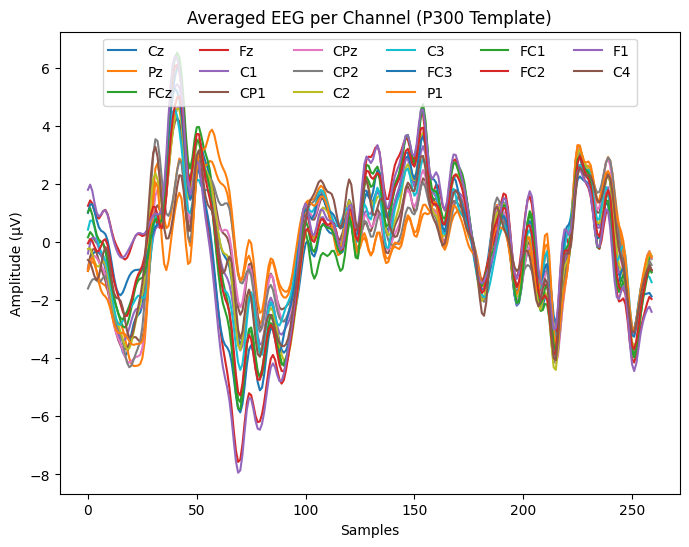

In [36]:
coherent_avg = np.mean(errp_data, axis=0)
print(coherent_avg.shape)

plt.figure(figsize=(8,6))
for ch in range(coherent_avg.shape[0]):
    plt.plot(coherent_avg[ch], label=f'{utils.important_channels[ch]}')
plt.title("Averaged EEG per Channel (P300 Template)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (μV)")
plt.legend(loc="upper center", ncol=6)
plt.show()

In [37]:
# time to resample and normalize
def resample_and_normalize(signal, S=16):
    """
    signal: shape (n_channels, T)
    S: number of segments (e.g., 16)
    Returns: list of resampled & normalized curves, one per channel
    """
    n_channels, T = signal.shape
    delta = T // (S + 1)
    
    resampled_curves = []
    for ch in range(n_channels):
        x = []
        y = []
        for s in range(S + 1):
            idx = s * delta
            if idx >= T:
                break
            x.append(idx)
            y.append(signal[ch, idx])
        
        x = np.array(x)
        y = np.array(y)
        x_norm = (x - x.min()) / (x.max() - x.min() + 1e-8)  # add epsilon to avoid divide by zero
        y_norm = (y - y.min()) / (y.max() - y.min() + 1e-8)
        
        resampled_curves.append((x_norm, y_norm))

    return resampled_curves  # list of (x, y) pairs per channel

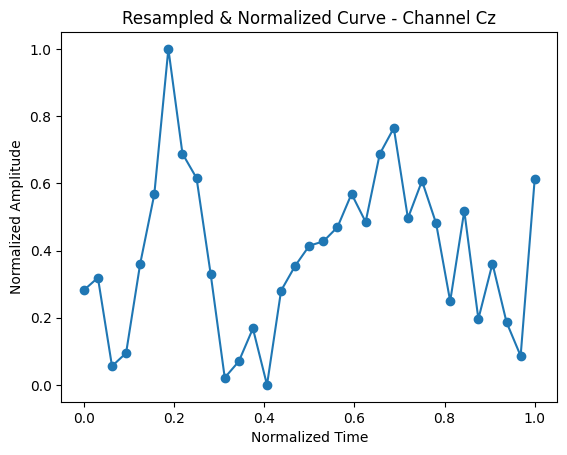

In [45]:
resampled_data = resample_and_normalize(coherent_avg, S=32)
#print(resampled_data.shape)

channel_id = 0
x0, y0 = resampled_data[channel_id]
plt.plot(x0, y0, marker='o')
plt.title(f"Resampled & Normalized Curve - Channel {utils.important_channels[channel_id]}")
plt.xlabel("Normalized Time")
plt.ylabel("Normalized Amplitude")
plt.show()

In [43]:
def plot_resampled_vs_original(template, resampled_curves, channel_idx=0):
    original = template[channel_idx]
    x_resampled, y_resampled = resampled_curves[channel_idx]
    
    # Normalize original curve for fair comparison
    orig_norm = (original - original.min()) / (original.max() - original.min() + 1e-8)
    t = np.linspace(0, 1, len(original))  # normalized time axis
    
    plt.figure(figsize=(10, 4))
    plt.plot(t, orig_norm, label='Original (Normalized)', linewidth=2)
    plt.plot(x_resampled, y_resampled, marker='o', label='Resampled (SHCC input)', linestyle='--')
    plt.title(f"Channel {channel_idx} – Normalized vs Resampled")
    plt.xlabel("Normalized Time")
    plt.ylabel("Normalized Amplitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

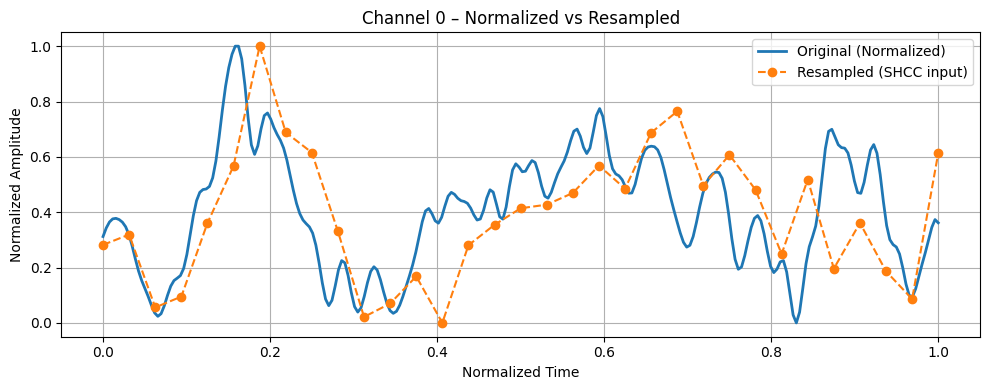

In [46]:
plot_resampled_vs_original(coherent_avg, resampled_data, channel_idx=channel_id)

In [47]:
def compute_shcc(x, y):
    """
    x, y: normalized coordinates of a resampled ERP curve
    Returns:
        SHCC chain code: np.array of slopes
    """
    slopes = []
    for i in range(len(x) - 1):
        dx = x[i+1] - x[i]
        dy = y[i+1] - y[i]
        slope = dy / (dx + 1e-8)  # avoid division by zero
        slopes.append(round(slope, 4))  # keep precision similar to paper

    return np.array(slopes)

In [51]:
# one chain per channel!
shcc_chains = [compute_shcc(x, y) for (x, y) in resampled_data]
print(len(shcc_chains), shcc_chains[0].shape)

chains = np.array(shcc_chains)
print(chains.shape)

16 (32,)
(16, 32)


In [54]:
def calc_tortuosity(chains):
    tor = []
    for i in range(chains.shape[0]):
        tor.append(np.sum(np.abs(np.floor(chains[i, :-1]) / 100)))
    return np.array(tor)

tortuosity = calc_tortuosity(chains)
print(tortuosity.shape) 
print(tortuosity)

(16,)
[1.66 1.84 1.56 1.24 1.64 1.8  1.71 1.98 1.88 1.73 1.4  1.62 1.56 1.52
 1.29 2.14]


In [61]:
def chains_distance(template_chains, trial_chains):
    distance = []
    for i in range(template_chains.shape[0]):
        distance.append(np.sum(np.abs(template_chains[i, :] - trial_chains[i, :])))
    return np.array(distance)

def area_differences(template_curve, trial_curve):
    A_template = 0.5 * (template_curve[:, :-1] + template_curve[:, 1:]) 
    A_candidate = 0.5 * (trial_curve[:, :-1] + trial_curve[:, 1:])

    segmentwise_diff = A_template - A_candidate
    total_diff = np.sum(np.abs(segmentwise_diff), axis=1) 

    return segmentwise_diff, total_diff

template_curve = []
for ch in range(len(utils.important_channels)):
    _, y = resampled_data[ch]
    template_curve.append(y)
template_curve = np.array(template_curve)
print(template_curve.shape)

(16, 33)


In [ ]:
def norm_similarity(x):
    return 1 - (x / (np.max(x) + 1e-6))  # invert: 1 = best match, 0 = worst

def calc_similarities(template_curve, template_chains, template_tortuosity, trial_curve, trial_chains, trial_tortuosity):
    # compute similarity per channel and at the end get the mean of all similarities
    _, area_diff = area_differences(template_curve, trial_curve)
    chains_dist = chains_distance(template_chains, trial_chains)
    tor_diff = np.abs(template_tortuosity - trial_tortuosity) # l1 norm

    return norm_similarity(area_diff), norm_similarity(chains_dist), norm_similarity(tor_diff)

calc_similarities(template_curve, chains, tortuosity, template_curve, chains, tortuosity) # should be all ones!

(array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

TODO: Weighted similarity, more types of similarities, run experiments!

In [20]:
# let's check the 5th session
raw_data = pd.read_csv('data/train/Data_S07_Sess05.csv')
fb_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
fb_indices = fb_times.index
filtered = utils.bandpass_filter_all(raw_data, highcut=30)

There are 100 feedback times


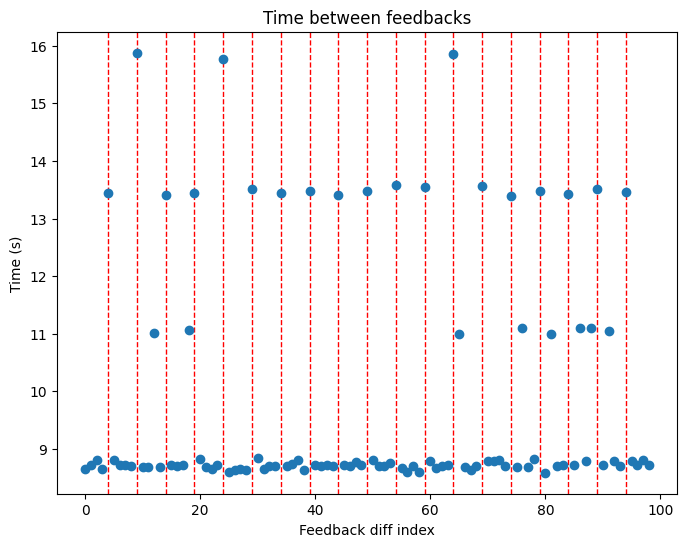

In [26]:
utils.plot_feedback_time_diffs(fb_times, fb_indices, save_png=True, png_name="S07_Sess05_fb_diffs")

There are 60 feedback times


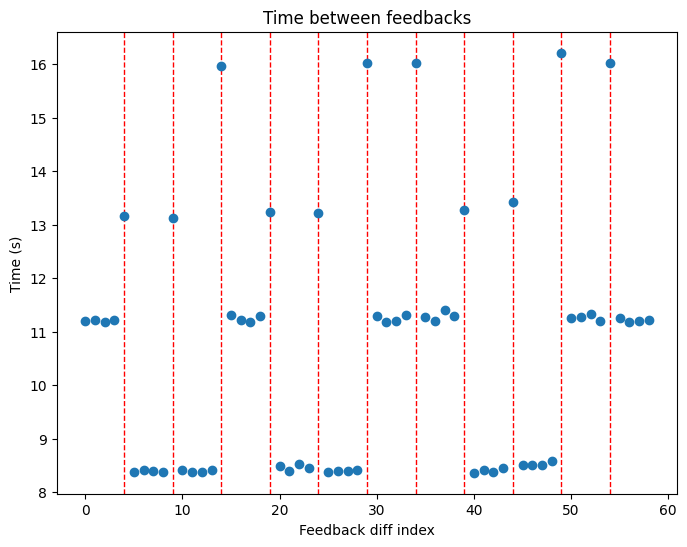

In [28]:
utils.plot_feedback_time_diffs(feedback_times, feedback_indices, save_png=True, png_name="S06_Sess04_fb_diffs")

In [47]:
time_diffs = {}
time_bounds = []
for subject in utils.train_subjects:
    time_diffs[subject] = []
    raw_data = pd.read_csv(f"data/train/Data_S{subject}_Sess05.csv")
    feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
    feedback_indices = feedback_times.index
    for i in range(len(feedback_indices)):
        if i > 0:
            diff = feedback_times.iloc[i] - feedback_times.iloc[i-1]
            time_diffs[subject].append(diff)
            if i%5 == 0 and (i-1) not in time_bounds: time_bounds.append(i-1)

In [34]:
print(time_diffs[utils.train_subjects[0]])

[np.float64(7.884999999999998), np.float64(10.130000000000003), np.float64(7.899999999999999), np.float64(7.869999999999997), np.float64(12.5), np.float64(7.864999999999995), np.float64(10.100000000000009), np.float64(10.099999999999994), np.float64(7.8700000000000045), np.float64(14.700000000000003), np.float64(7.8799999999999955), np.float64(10.134999999999991), np.float64(7.900000000000006), np.float64(7.884999999999991), np.float64(12.515000000000015), np.float64(7.884999999999991), np.float64(10.150000000000006), np.float64(7.884999999999991), np.float64(7.880000000000024), np.float64(12.35499999999999), np.float64(10.150000000000006), np.float64(10.129999999999995), np.float64(7.884999999999991), np.float64(10.150000000000006), np.float64(12.464999999999975), np.float64(10.120000000000005), np.float64(7.865000000000009), np.float64(10.134999999999991), np.float64(10.135000000000048), np.float64(12.479999999999961), np.float64(7.8700000000000045), np.float64(7.865000000000009), np

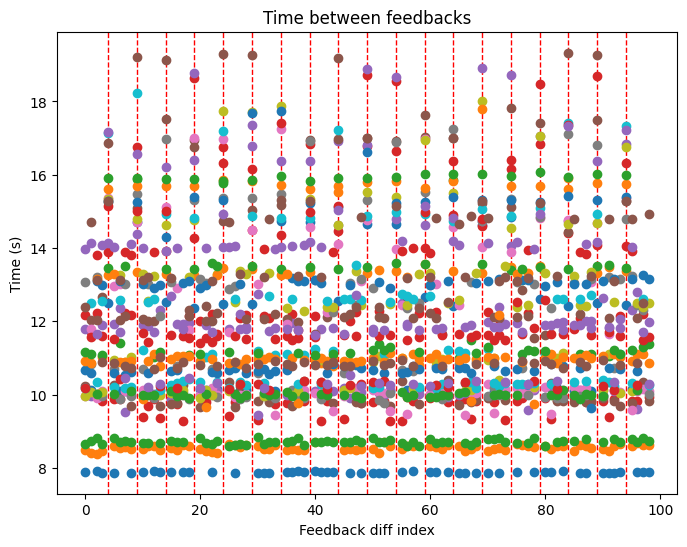

In [35]:
plt.figure(figsize=(8,6))
for x_line in time_bounds:
    plt.axvline(x=x_line, color='r', linestyle='--', linewidth=1)
for key in time_diffs.keys():
    plt.plot(time_diffs[key], 'o')
plt.xlabel("Feedback diff index")
plt.ylabel("Time (s)")
plt.title("Time between feedbacks")
plt.show()

There are 100 feedback times


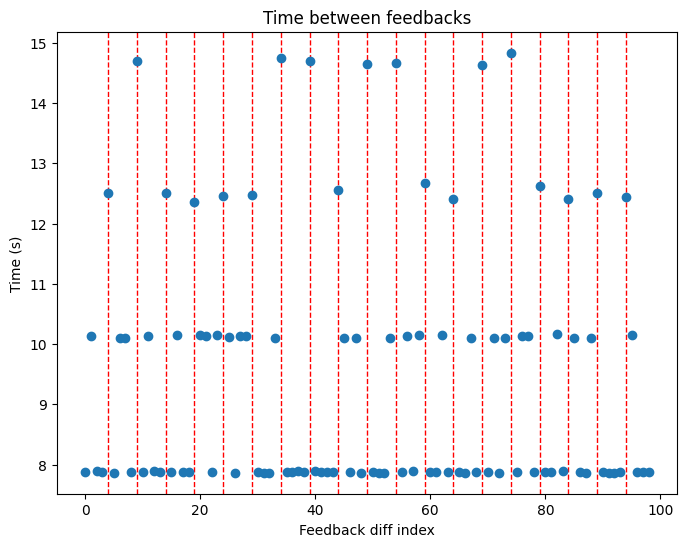

There are 100 feedback times


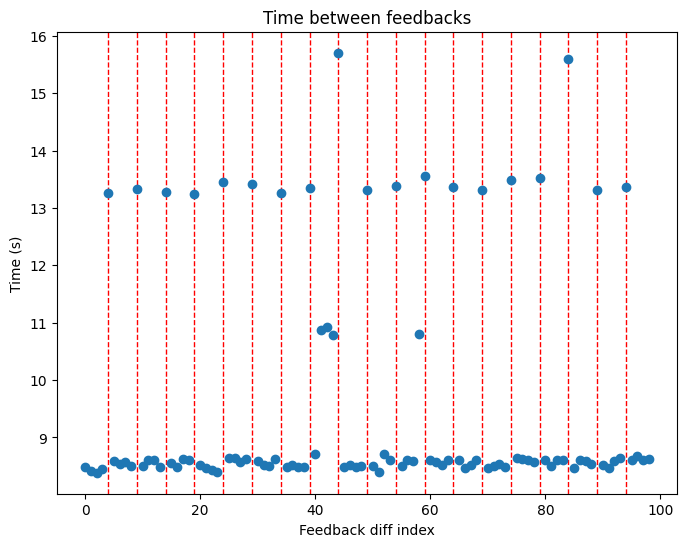

There are 100 feedback times


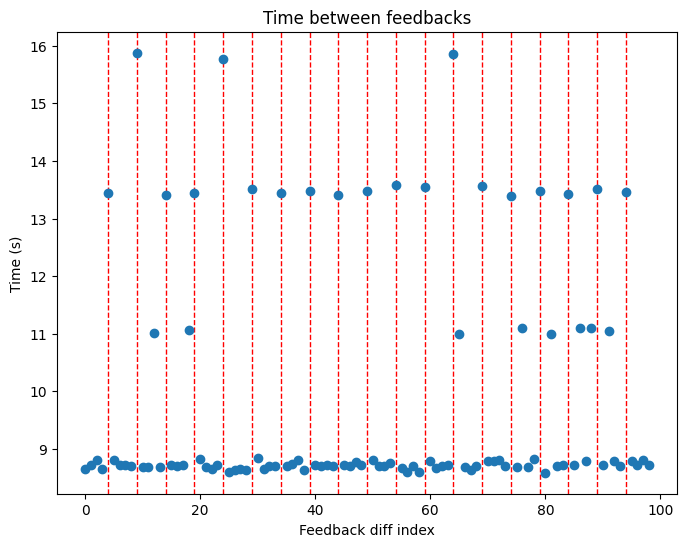

There are 100 feedback times


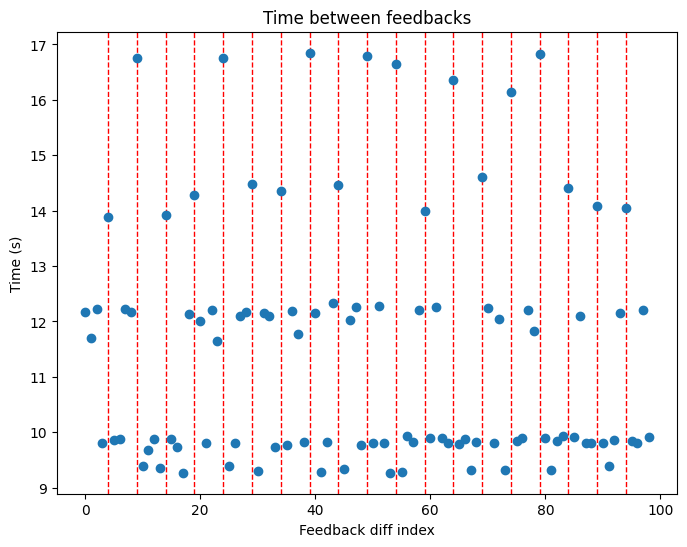

There are 100 feedback times


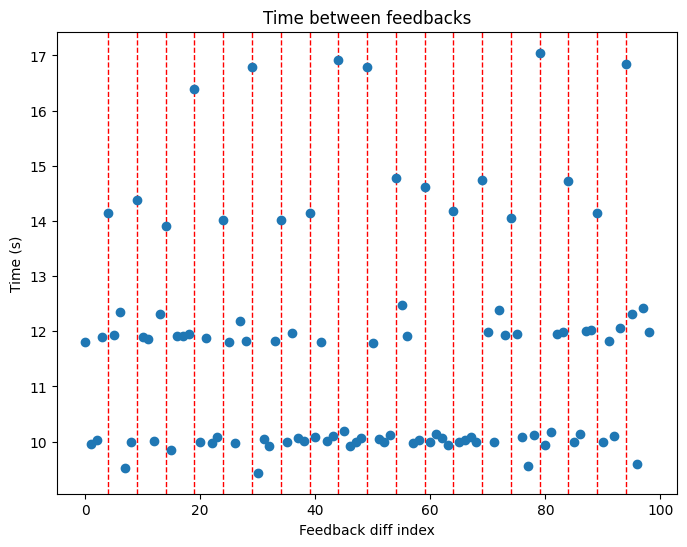

There are 100 feedback times


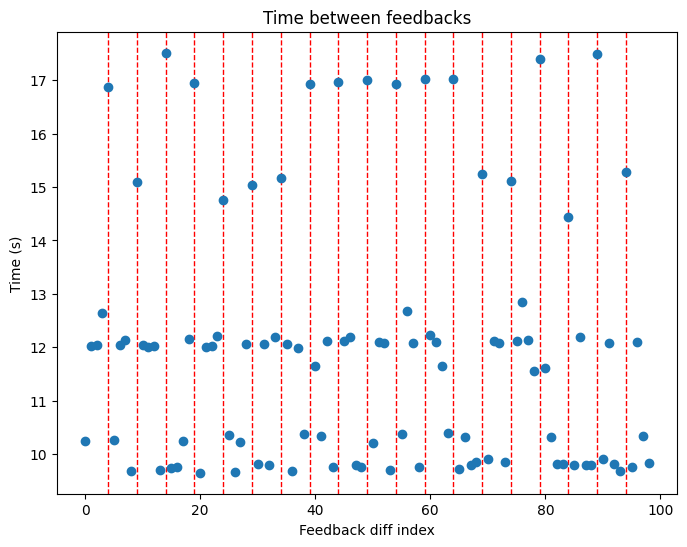

There are 100 feedback times


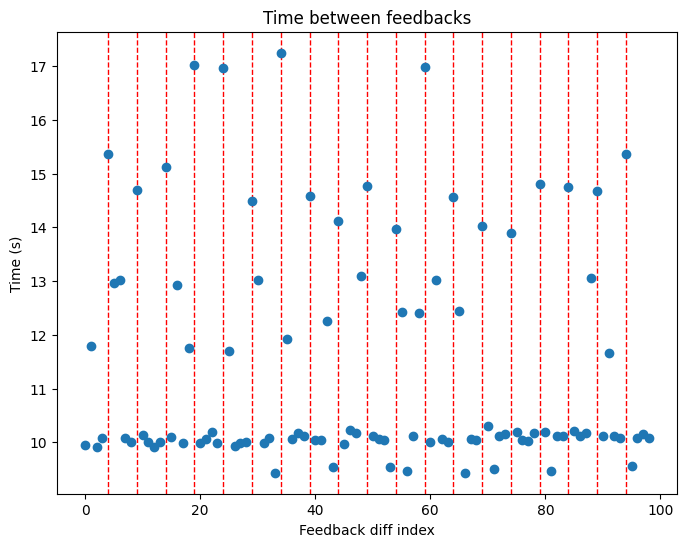

There are 100 feedback times


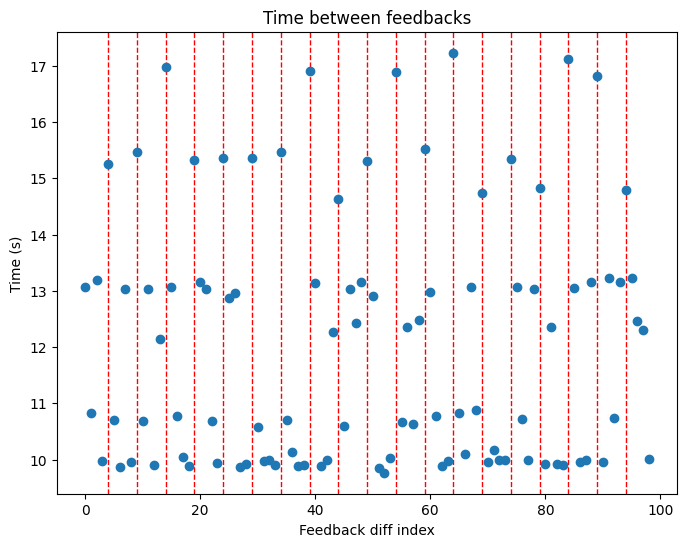

There are 100 feedback times


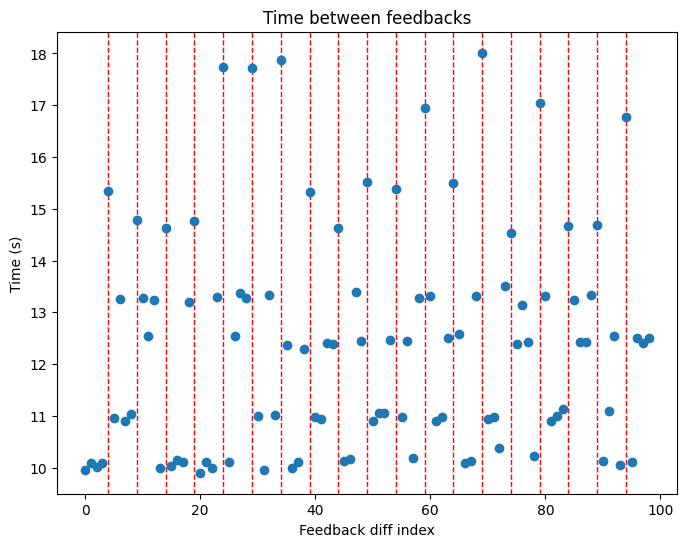

There are 100 feedback times


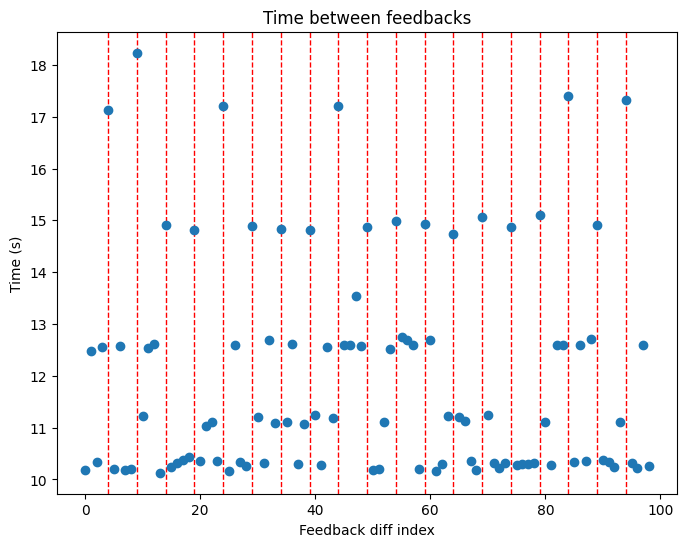

There are 100 feedback times


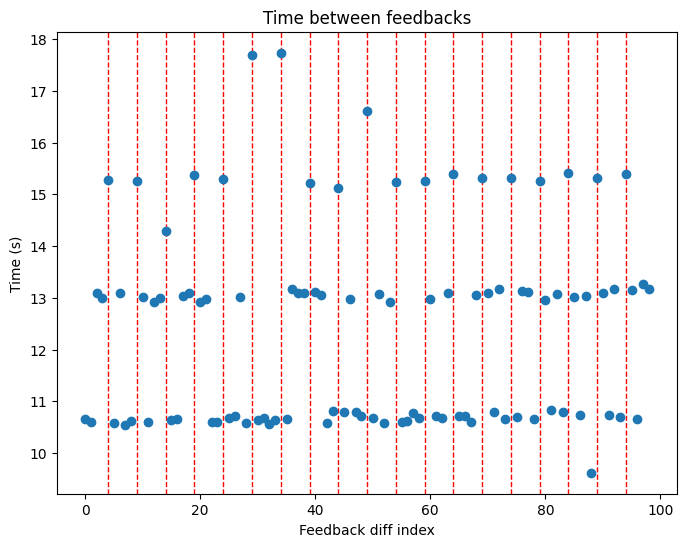

There are 100 feedback times


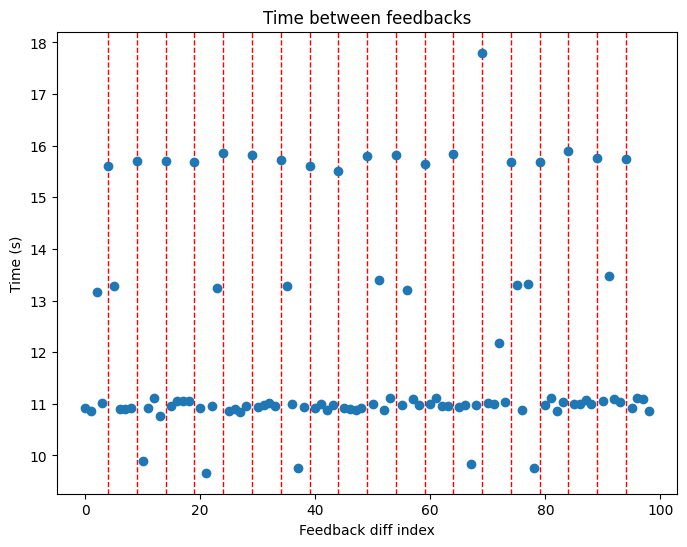

There are 100 feedback times


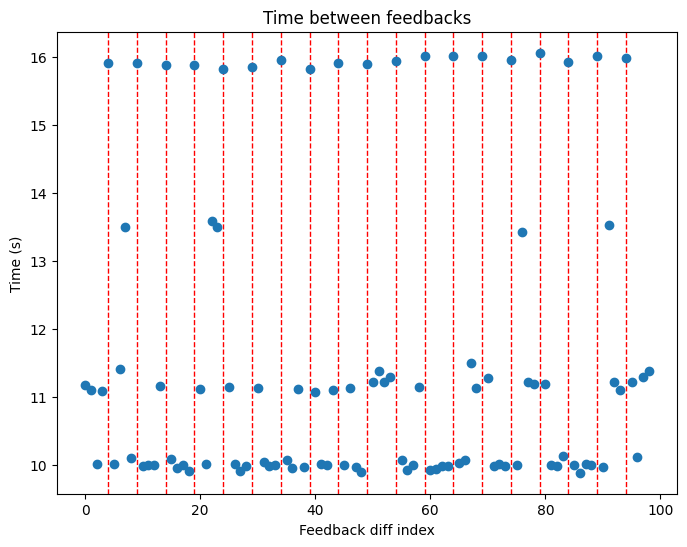

There are 100 feedback times


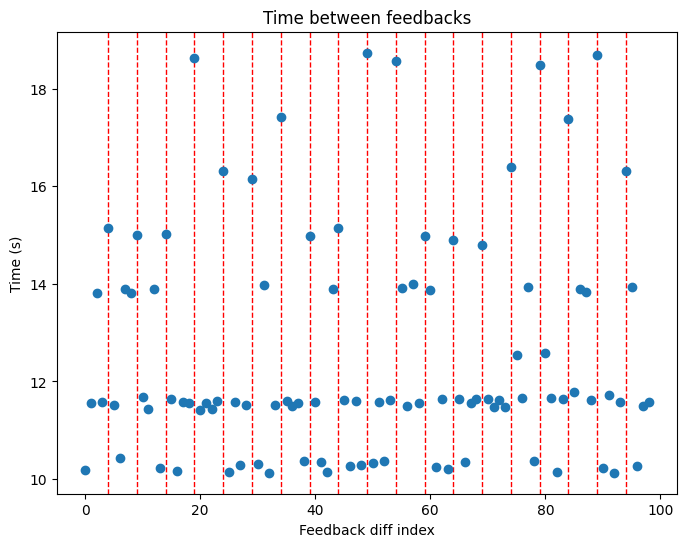

There are 100 feedback times


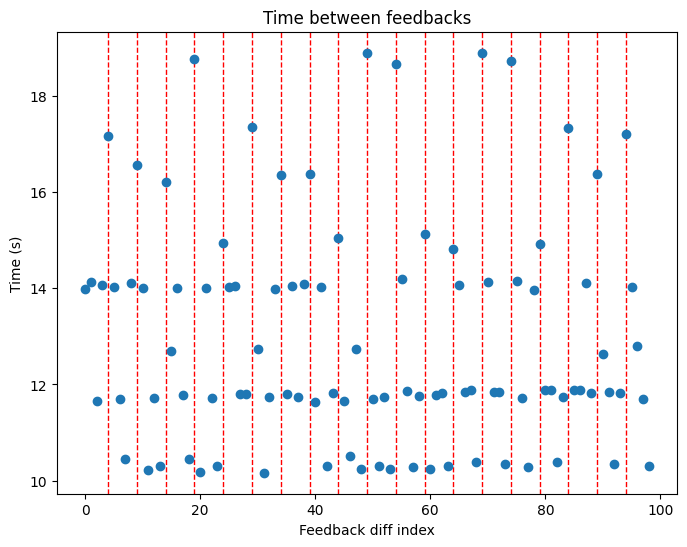

There are 100 feedback times


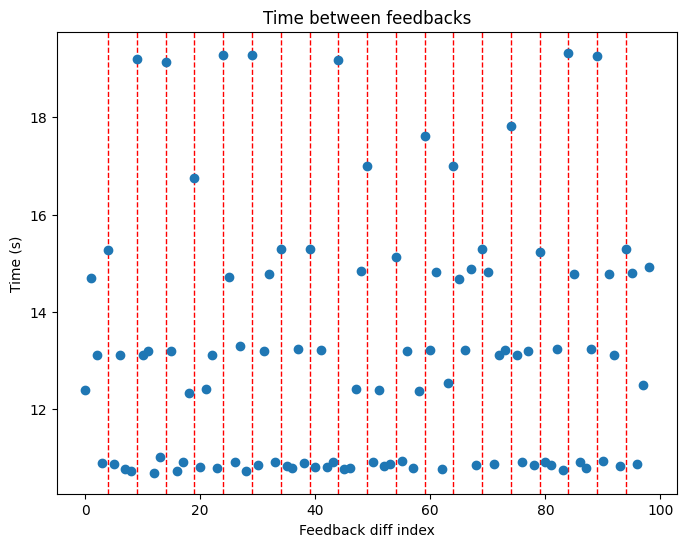

In [36]:
for subject in utils.train_subjects:
    raw_data = pd.read_csv(f"data/train/Data_S{subject}_Sess05.csv")
    feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
    feedback_indices = feedback_times.index
    utils.plot_feedback_time_diffs(feedback_times, feedback_indices)

In [2]:
def cluster_time_diff(diff_values, n_clusters=4):
    diff_values = diff_values.reshape(-1, 1)  # shape (n_samples, 1)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(diff_values)
    return labels

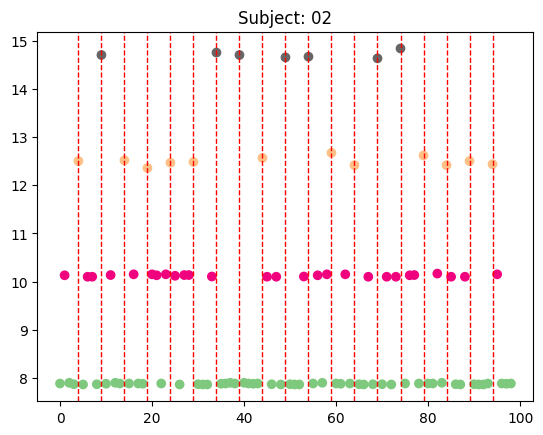

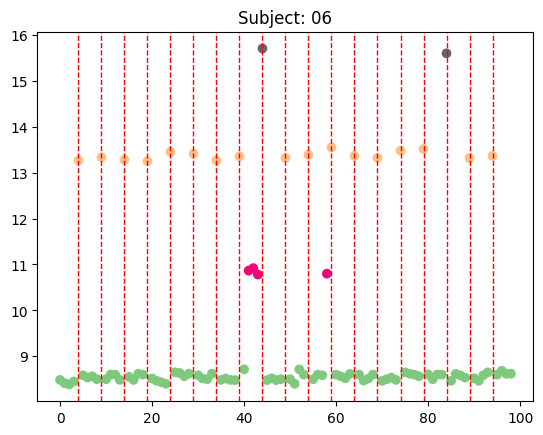

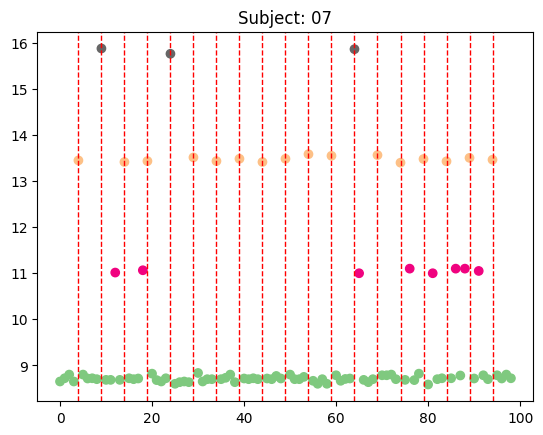

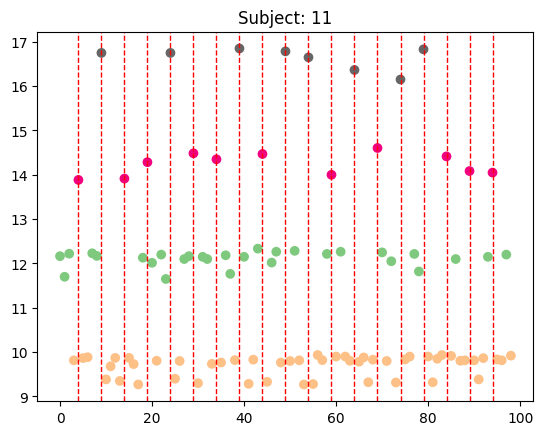

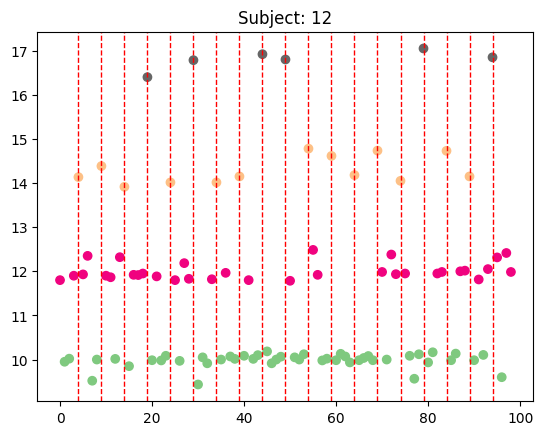

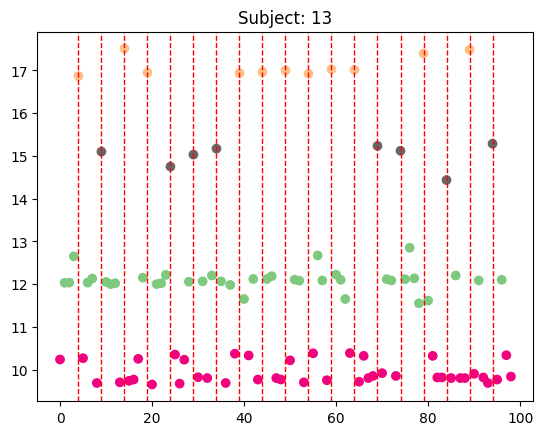

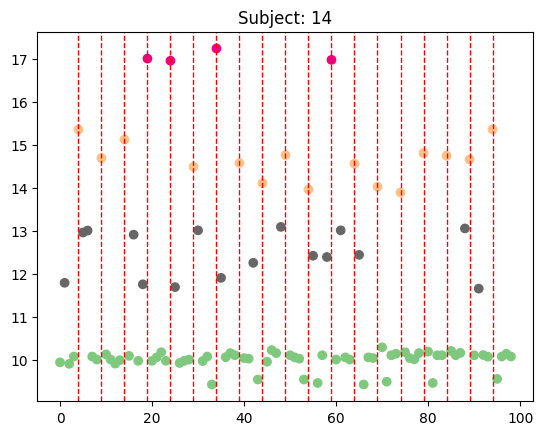

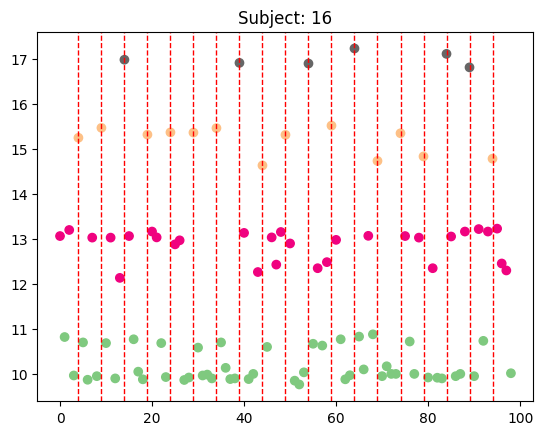

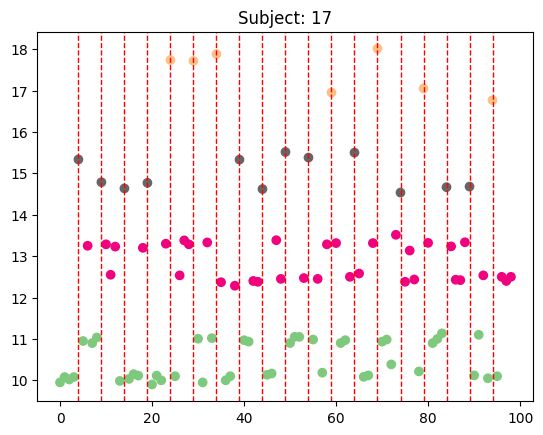

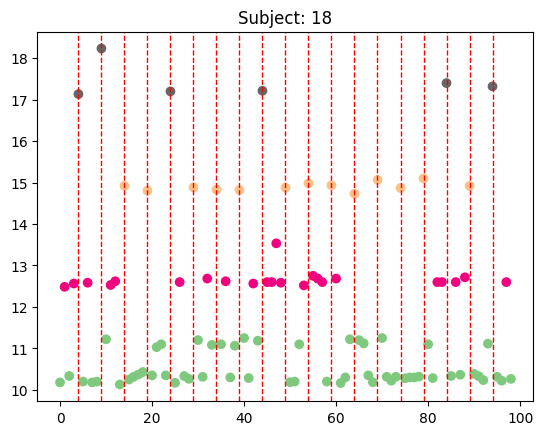

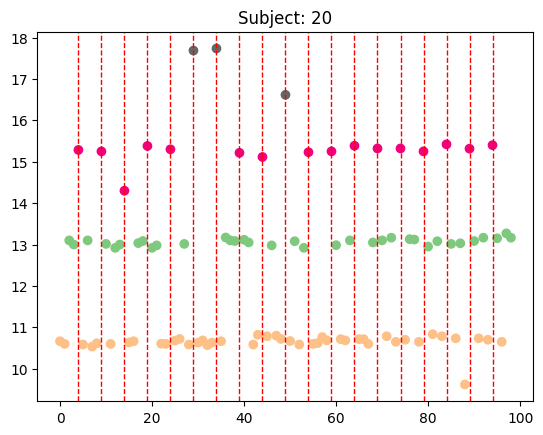

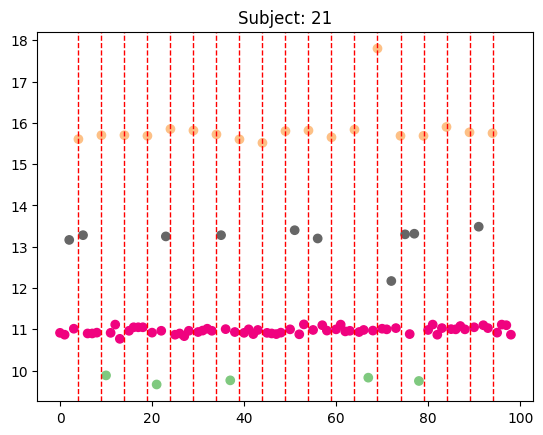

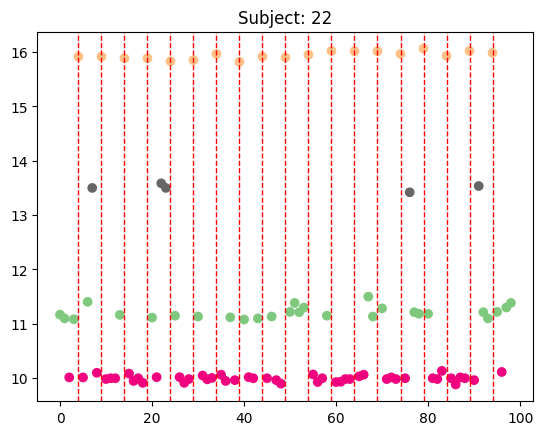

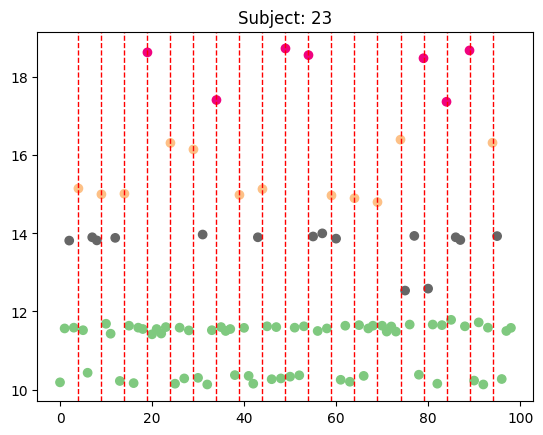

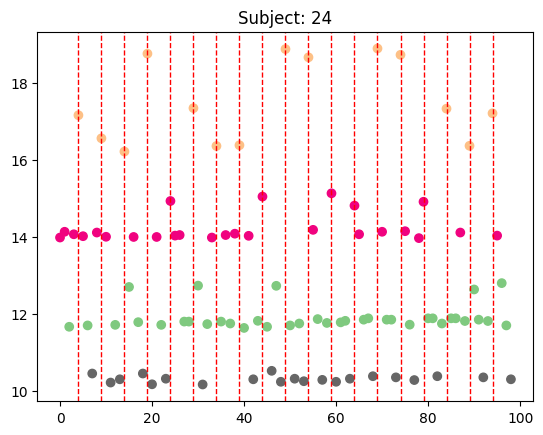

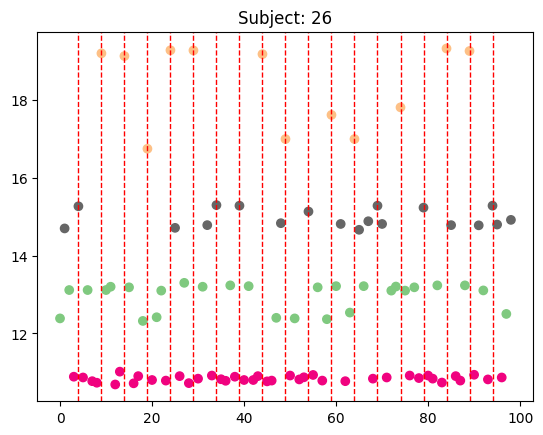

In [ ]:
for key in time_diffs.keys():
    plt.figure()
    for x_line in time_bounds:
        plt.axvline(x=x_line, color='r', linestyle='--', linewidth=1)
    labels = cluster_time_diff(np.array(time_diffs[key]))
    plt.scatter(range(len(time_diffs[key])), time_diffs[key], c=labels, cmap='Accent')
    plt.title(f"Subject: {key}")
    plt.show()

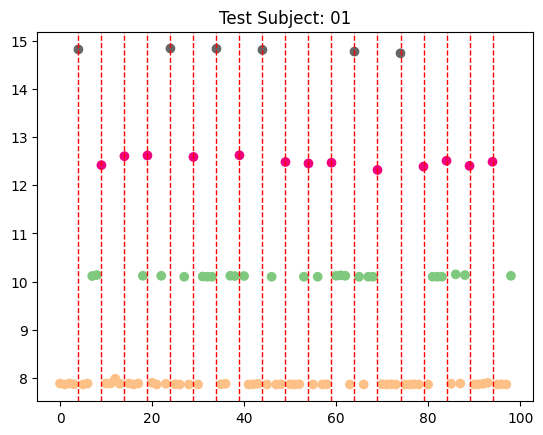

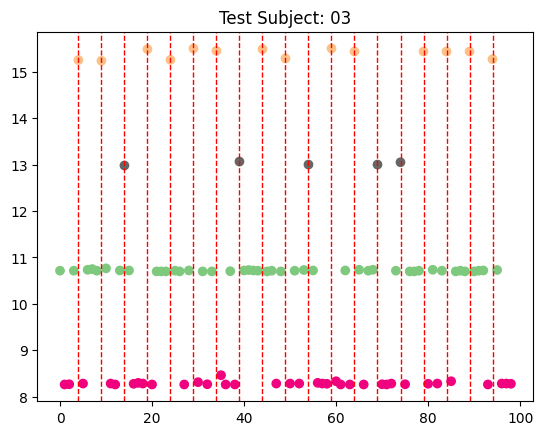

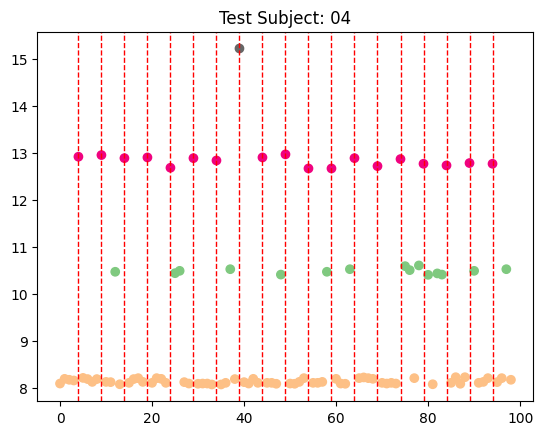

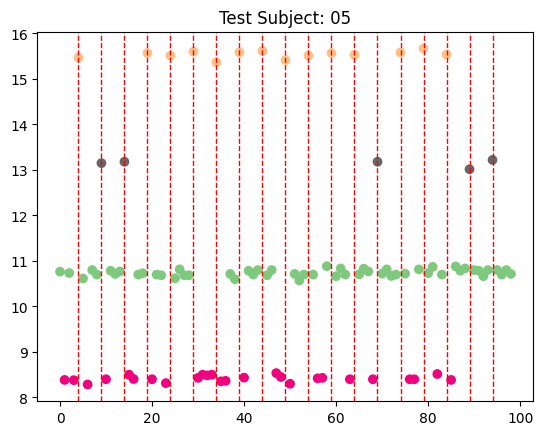

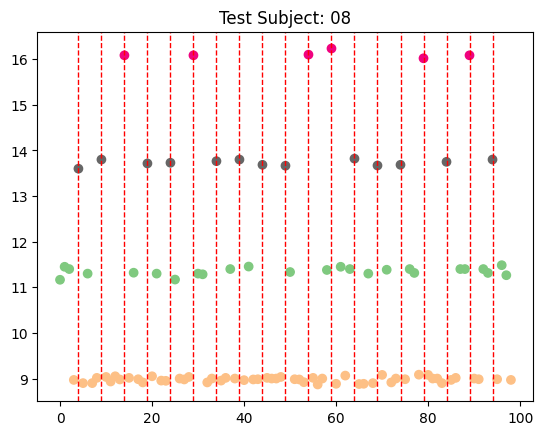

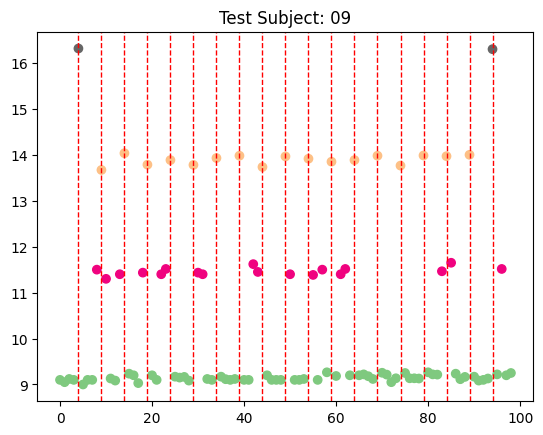

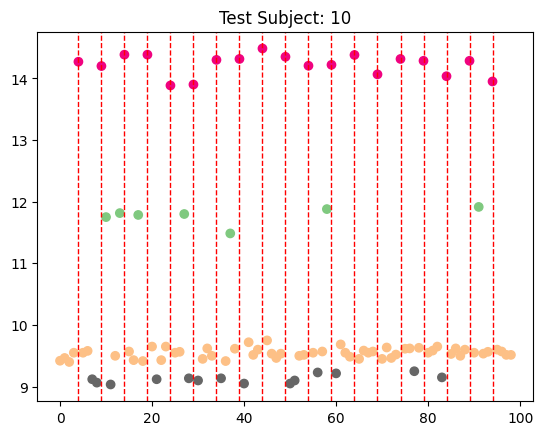

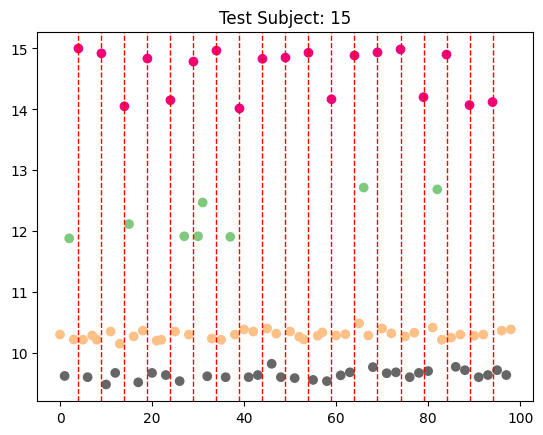

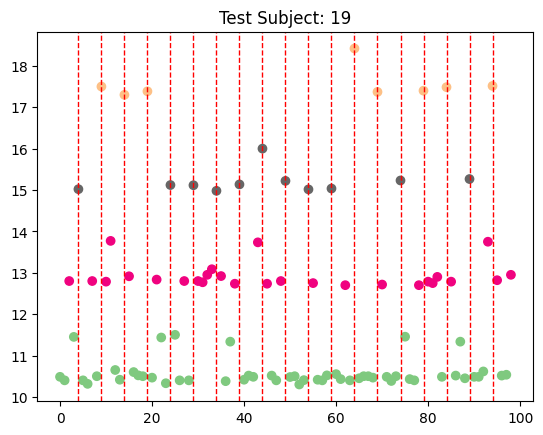

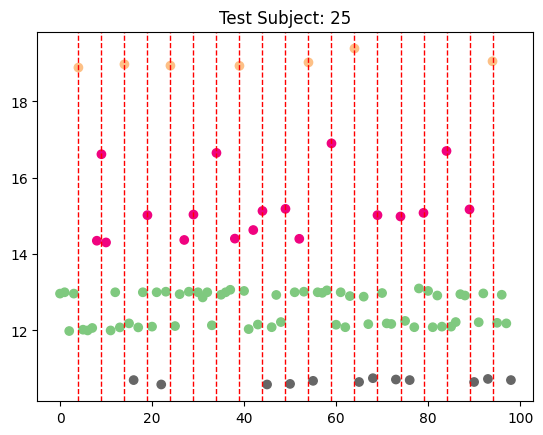

In [52]:
for subject in utils.test_subjects:
    raw_data = pd.read_csv(f"data/test/Data_S{subject}_Sess05.csv")
    feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
    feedback_indices = feedback_times.index
    time_diffs = []
    time_bounds = []
    for i in range(1, len(feedback_indices)):
        diff = feedback_times.iloc[i] - feedback_times.iloc[i-1]
        time_diffs.append(diff)
        if i%5 == 0: time_bounds.append(i-1)
    plt.figure()
    for x_line in time_bounds:
        plt.axvline(x=x_line, color='r', linestyle='--', linewidth=1)
    labels = cluster_time_diff(np.array(time_diffs))
    plt.scatter(range(len(time_diffs)), time_diffs, c=labels, cmap='Accent')
    plt.title(f"Test Subject: {subject}")
    plt.show()

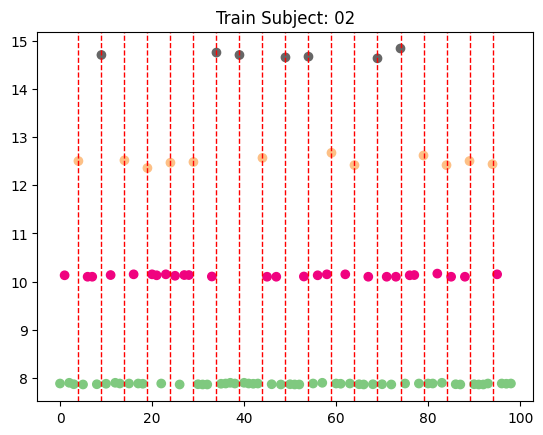

In [3]:
subject = utils.train_subjects[0]
raw_data = pd.read_csv(f"data/train/Data_S{subject}_Sess05.csv")
feedback_times = raw_data[raw_data['FeedBackEvent'] == 1]['Time']
feedback_indices = feedback_times.index
time_diffs = []
time_bounds = []
for i in range(1, len(feedback_indices)):
    diff = feedback_times.iloc[i] - feedback_times.iloc[i-1]
    time_diffs.append(diff)
    if i%5 == 0: time_bounds.append(i-1)
plt.figure()
for x_line in time_bounds:
    plt.axvline(x=x_line, color='r', linestyle='--', linewidth=1)
labels = cluster_time_diff(np.array(time_diffs))
plt.scatter(range(len(time_diffs)), time_diffs, c=labels, cmap='Accent')
plt.title(f"Train Subject: {subject}")
plt.show()

In [5]:
levels = {0:[], 1:[], 2:[], 3:[]}
for i in range(len(labels)):
    levels[labels[i]].append(time_diffs[i])
print(levels)
for key in levels.keys():
    levels[key] = np.mean(levels[key])
print(levels)

sorted_keys = sorted(levels, key=levels.get)
print(sorted_keys)
correction_labels = [sorted_keys[1], sorted_keys[3]]
normal_labels = [sorted_keys[0], sorted_keys[2]]
print(correction_labels, normal_labels)

{0: [np.float64(7.884999999999998), np.float64(7.899999999999999), np.float64(7.869999999999997), np.float64(7.864999999999995), np.float64(7.8700000000000045), np.float64(7.8799999999999955), np.float64(7.900000000000006), np.float64(7.884999999999991), np.float64(7.884999999999991), np.float64(7.884999999999991), np.float64(7.880000000000024), np.float64(7.884999999999991), np.float64(7.865000000000009), np.float64(7.8700000000000045), np.float64(7.865000000000009), np.float64(7.865000000000009), np.float64(7.880000000000052), np.float64(7.884999999999991), np.float64(7.899999999999977), np.float64(7.884999999999991), np.float64(7.900000000000034), np.float64(7.884999999999991), np.float64(7.8799999999999955), np.float64(7.884999999999991), np.float64(7.8700000000000045), np.float64(7.865000000000009), np.float64(7.8700000000000045), np.float64(7.865000000000009), np.float64(7.865000000000009), np.float64(7.884999999999991), np.float64(7.899999999999977), np.float64(7.884999999999991